In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
from libs import gif, nb_utils

In [2]:

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

yeni session başlatılır.

In [3]:
sess = tf.InteractiveSession()

Google inception model çalıştırılarak önceden eğitilmiş ve bütün hiper parametreleri eğitilmiştir. Bu sebeple tamamlanmış bir model üzerinde konuşularak nihai hedefte yapılmak istenen anlatılabilinir. Yarıdmcı fonksiyonları kullanılarak google model elde edilir. 

Githuba modeli indirmek için kod eklenmiştir. 


In [4]:
from libs import inception
net = inception.get_inception_model()

Here's a little extra that wasn't in the lecture.  We can visualize the graph definition using the `nb_utils` module's `show_graph` function.  This function is taken from an example in the Tensorflow repo so I can't take credit for it!  It uses Tensorboard, which we didn't get a chance to discuss, Tensorflow's web interface for visualizing graphs and training performance.  It is very useful but we sadly did not have enough time to discuss this!

In [5]:
nb_utils.show_graph(net['graph_def'])

tensorflow görüntüleme yardımcı kütüphaneleri ile büyük resimde inception için kullanılan model gösterilmiştir. 


In [6]:
tf.import_graph_def(net['graph_def'], name='inception')

bütün laballer labels denen indekte tutulmaktadir. İlk 10 tanesi yazdıralım. 

In [7]:
print(net['labels'][1:10])
len(net['labels'])

[(1, 'kit fox'), (2, 'English setter'), (3, 'Siberian husky'), (4, 'Australian terrier'), (5, 'English springer'), (6, 'grey whale'), (7, 'lesser panda'), (8, 'Egyptian cat'), (9, 'ibex')]


1001

<TODO: visual of graph>

Görüntüdeki network'ün bütün elemanları isim olarak belirtildiği için herbir elamanına ulaşılabilir ve her bir elamanı üzerinden işlem yapılabilir. Bütün elemanlar büyük bir liste oluşturmaktadır. Şimdi isimlerine bakalım. 


In [8]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names)

['inception/input', 'inception/conv2d0_w', 'inception/conv2d0_b', 'inception/conv2d1_w', 'inception/conv2d1_b', 'inception/conv2d2_w', 'inception/conv2d2_b', 'inception/mixed3a_1x1_w', 'inception/mixed3a_1x1_b', 'inception/mixed3a_3x3_bottleneck_w', 'inception/mixed3a_3x3_bottleneck_b', 'inception/mixed3a_3x3_w', 'inception/mixed3a_3x3_b', 'inception/mixed3a_5x5_bottleneck_w', 'inception/mixed3a_5x5_bottleneck_b', 'inception/mixed3a_5x5_w', 'inception/mixed3a_5x5_b', 'inception/mixed3a_pool_reduce_w', 'inception/mixed3a_pool_reduce_b', 'inception/mixed3b_1x1_w', 'inception/mixed3b_1x1_b', 'inception/mixed3b_3x3_bottleneck_w', 'inception/mixed3b_3x3_bottleneck_b', 'inception/mixed3b_3x3_w', 'inception/mixed3b_3x3_b', 'inception/mixed3b_5x5_bottleneck_w', 'inception/mixed3b_5x5_bottleneck_b', 'inception/mixed3b_5x5_w', 'inception/mixed3b_5x5_b', 'inception/mixed3b_pool_reduce_w', 'inception/mixed3b_pool_reduce_b', 'inception/mixed4a_1x1_w', 'inception/mixed4a_1x1_b', 'inception/mixed4a_3

Giriş değerleri ilk tensor değerinde verilmekte ve kategorize edilmesi beklenilen 1000 adet nesne için olasılıksal değerler ise son katmanda bulunmaktadır. 


In [9]:
# 0 indexte ilk katman olan data layer bulunmaktadır. 
input_name = names[0] + ':0'
x = g.get_tensor_by_name(input_name)

In [10]:
softmax = g.get_tensor_by_name(names[-1] + ':0')

Pointer şeklinde hem giriş hemde çıkış methodu elimizde. Görüntüyü verip içerisinden geçirerek bir görüntü için sonuç değeri alabilecek seviyeye geldik. 

<a name="predicting-with-the-inception-network"></a>
##  Inception Ağı ile görüntü ilk tahmini



0 255


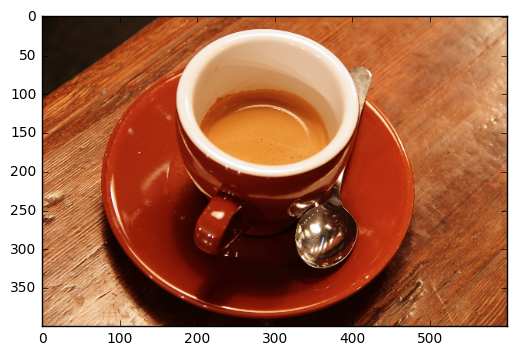

In [11]:
from skimage.data import coffee
og = coffee()
plt.imshow(og)
print(og.min(), og.max())

Görüntü inception görüntülerinde olan ilk işlemler uygulanır. Böylece girdiler aynı olması sağlanır.


In [ ]:
# Note that in the lecture, I used a slightly different inception
# model, and this one requires us to subtract the mean from the input image.
# The preprocess function will also crop/resize the image to 299x299
img = inception.preprocess(og)
print(og.shape), print(img.shape)

In [ ]:
# So this will now be a different range than what we had in the lecture:
print(img.min(), img.max())

Görüntüye ekstra bir boyut eklenerek batch şekilde çalışması sağlanır. 

In [ ]:
img_4d = img[np.newaxis]
print(img_4d.shape)

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(og)

# Note that unlike the lecture, we have to call the `inception.deprocess` function
# so that it adds back the mean!
axs[1].imshow(inception.deprocess(img))

In [ ]:
res = np.squeeze(softmax.eval(feed_dict={x: img_4d}))

In [ ]:
# Note that this network is slightly different than the one used in the lecture.
# Instead of just 1 output, there will be 16 outputs of 1008 probabilities.
# We only use the first 1000 probabilities (the extra ones are for negative/unseen labels)
res.shape

Sonuç vektörü 1000 adet elamandan oluşan bir vektör olmaktadır. Networkün içinde bütün etiketler için değerler bulunmaktadır. Böylece değerleri üzerinden sıralama yaparak en iyi sonucu veren 5 değer elde edilebilir. 


In [ ]:
# Note that this is one way to aggregate the different probabilities.  We could also
# take the argmax.
res = np.mean(res, 0)
res = res / np.sum(res)

In [ ]:
print([(res[idx], net['labels'][idx])
       for idx in res.argsort()[-5:][::-1]])

<a name="visualizing-filters"></a>
##  Filtrelerin Görüntülenmesi 

Sistemin Çalıştığını gördükten sonra nasıl çalıştığını anlamak için öncelikle ilk katmandaki filtrelerin görselleştirilmesini yapalım.

In [ ]:
W = g.get_tensor_by_name('inception/conv2d0_w:0')
W_eval = W.eval()
print(W_eval.shape)

Görüldüğü gübü 7 X 7 X 3 X 64 boyutunda bir matristen oluşmaktadır ilk katmandaki filtreler. Bunun görselleştirilmesi için biraz python trick kullanılarak 64 adet 7 X 7 X 3 lük matris görüntü şekilinde görselleştirilir. 


In [ ]:
from libs import utils
W_montage = utils.montage_filters(W_eval)
plt.figure(figsize=(10,10))
plt.imshow(W_montage, interpolation='nearest')

RGB değerlerini gösterirsek  edersek 

In [ ]:
Ws = [utils.montage_filters(W_eval[:, :, [i], :]) for i in range(3)]
Ws = np.rollaxis(np.array(Ws), 0, 3)
plt.figure(figsize=(10,10))
plt.imshow(Ws, interpolation='nearest')

Daha iyi görmek için filtreler normalize edildiğinde ise 

In [ ]:
np.min(Ws), np.max(Ws)
Ws = (Ws / np.max(np.abs(Ws)) * 128 + 128).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.imshow(Ws, interpolation='nearest')

gibi filtreler görülmektedir. Gabor filtreleri gibi görülen bu filtreler bazıları köşelere kenarlara, yatay dikey gibi cevaplar vermektedir. 

In [ ]:
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')

Let's look at the shape:

In [ ]:
layer_shape = tf.shape(feature).eval(feed_dict={x:img_4d})
print(layer_shape)

filtrelerin herbiri tek tek görüntülere uygulandığında ise son resimki gibi hangi filtrelerin hangi filtrelerin hangi özellikler üzerinde daha hassas oldukları anlaşılmaktadır. 


In [ ]:
f = feature.eval(feed_dict={x: img_4d})
montage = utils.montage_filters(np.rollaxis(np.expand_dims(f[0], 3), 3, 2))
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(inception.deprocess(img))
axs[0].set_title('Original Image')
axs[1].imshow(Ws, interpolation='nearest')
axs[1].set_title('Convolution Filters')
axs[2].imshow(montage, cmap='gray')
axs[2].set_title('Convolution Outputs')

In [ ]:
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
gradient = tf.gradients(tf.reduce_max(feature, 3), x)

Sonraki katmanlarda elde edilen ağırlıkların görüntülenmesi ilk katman gibi kolay olmamaktadır. Daha çok birden fazla değer alarak bu değerlerin üzerinden işlem yapılmakda olduğu için bu değerler direk gösterimi için başka bir yöntem kullanılması gerekmektedir. Bu yöntemde o katmandaki değere kadar kullanılan filtrenin etkisi anlaşılması için öncelikle o katmana kadar bir iler besleme sonrasında ise bir geriye doğru besleme gerçekleştirilerek bu katmanların görüntü üzerindeki etkisi görülebilir. 

Aslında görüntüye kadar olan katmanda elde edilen bir path yani aktifleşme yolunun geriye doğru beslenemsi ile hangi piksellerin ilgili katmanda nereye denk geldiği gösterilmektedir. 


Bir ileri besleme sonrasında yukarı doğru bir gradient alma işlemi sonrasında 

In [ ]:
res = sess.run(gradient, feed_dict={x: img_4d})[0]

aktive olan kısımlar elde edilmiş görselleştirilmek istendiğinde ise 

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(inception.deprocess(img))
axs[1].imshow(res[0])

Şeklinde bir görselleştirme elde edilmektedir. 


In [ ]:
def normalize(img, s=0.1):
    '''Normalize the image range for visualization'''
    z = img / np.std(img)
    return np.uint8(np.clip(
        (z - z.mean()) / max(z.std(), 1e-4) * s + 0.5,
        0, 1) * 255)

In [ ]:
r = normalize(res)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(inception.deprocess(img))
axs[1].imshow(r[0])

ilgili dğzeltmelerden sonra görüntü daha iyi nelere tepki verdiği görülmektedir. 

şimdi her bir layerdeki bir neuronun etkisini aynı yöntem ile hesaplamak için bir method haline getirelim işlemi.


In [ ]:
def compute_gradient(input_placeholder, img, layer_name, neuron_i):
    feature = g.get_tensor_by_name(layer_name)
    gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), x)
    res = sess.run(gradient, feed_dict={input_placeholder: img})[0]
    return res

def compute_gradients(input_placeholder, img, layer_name):
    feature = g.get_tensor_by_name(layer_name)
    layer_shape = tf.shape(feature).eval(feed_dict={input_placeholder: img})
    gradients = []
    for neuron_i in range(layer_shape[-1]):
        gradients.append(compute_gradient(input_placeholder, img, layer_name, neuron_i))
    return gradients

Şimdi herbir layerdeki neuron için layer ismi göndermek yeterlidir. O layerdeki neuronların etkisi bitleştirilmiş resimde şekildeki gibidir .


In [ ]:
gradients = compute_gradients(x, img_4d, 'inception/conv2d1_pre_relu:0')
gradients_norm = [normalize(gradient_i[0]) for gradient_i in gradients]
montage = utils.montage(np.array(gradients_norm))

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(montage)

In [ ]:
features = [name for name in names if 'maxpool' in name.split()[-1]]
print(features)

şimdi pooling layer için aynı işlemi yapalım. Ve bütün pooling işlemlerinden sonra görüntünün değişimini gösterelim.

In [ ]:
n_plots = len(features) + 1
fig, axs = plt.subplots(1, n_plots, figsize=(20, 5))
base = img_4d
axs[0].imshow(inception.deprocess(img))
for feature_i, featurename in enumerate(features):
    feature = g.get_tensor_by_name(featurename + ':0')
    neuron = tf.reduce_max(feature, len(feature.get_shape())-1)
    gradient = tf.gradients(tf.reduce_sum(neuron), x)
    this_res = sess.run(gradient[0], feed_dict={x: base})[0]
    axs[feature_i+1].imshow(normalize(this_res))
    axs[feature_i+1].set_title(featurename)

görüntüde bir resimde networkün nerelere odaklandığı görülebilmektedir. her bir pool layeri daha çok görüntünün fıncan kısmına odaklandığı görülebilmektedir. 
